In [36]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install optbinning[distributed]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.2-cp38-cp38-linux_x86_64.whl size=398567 sha256=1b1e3ea83351102d57fa71917242ebf9743b5f7cb9efe3d49c842a41d5a25399
  Stored in directory: /root/.cache/pip/wheels/c9/39/d2/c9a954f11bc1b2f95258a48cbd19b0767fe7d3bb061df95a5f
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-py3-none-any.whl size=2223 sha256=9b119bbf6441f1b69fc870e1aa32714444a6f976ebcc83afe4a5aa889dfbeb85
  Stored in directory: /root/.cache/pip/wheels/a0/6f/f6/c041bdb344311e31ea28717a6b0ae6106f951f8470329c2cb6
Successfully built accumulation-tree pyudorandom


In [38]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from pyspark.sql import SparkSession
import os
from wget import download
import pandas as pd
from optbinning import OptimalBinningSketch

In [40]:
spark = SparkSession.builder.getOrCreate()

df_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('CreditRiskDataColab.csv')

n_partitions = 4
df = df_data.repartition(n_partitions)

df_data.printSchema()

root
 |-- GoodCredit: integer (nullable = true)
 |-- checkingstatus: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- history: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- amount: integer (nullable = true)
 |-- savings: string (nullable = true)
 |-- employ: string (nullable = true)
 |-- installment: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- others: string (nullable = true)
 |-- residence: integer (nullable = true)
 |-- property: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- otherplans: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- cards: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- liable: integer (nullable = true)
 |-- tele: string (nullable = true)
 |-- foreign: string (nullable = true)



In [41]:
# Show stats
print("Number of records: " + str(df_data.count()))
df_data.show(1)

Number of records: 1000
+----------+--------------+--------+-------+-------+------+-------+------+-----------+------+------+---------+--------+---+----------+-------+-----+----+------+----+-------+
|GoodCredit|checkingstatus|duration|history|purpose|amount|savings|employ|installment|status|others|residence|property|age|otherplans|housing|cards| job|liable|tele|foreign|
+----------+--------------+--------+-------+-------+------+-------+------+-----------+------+------+---------+--------+---+----------+-------+-----+----+------+----+-------+
|         0|           A11|       6|    A34|    A43|  1169|    A65|   A75|          4|   A93|  A101|        4|    A121| 67|      A143|   A152|    2|A173|     1|A192|   A201|
+----------+--------------+--------+-------+-------+------+-------+------+-----------+------+------+---------+--------+---+----------+-------+-----+----+------+----+-------+
only showing top 1 row



In [52]:
variable = "Age"
target = "GoodCredit"
columns = [variable, target]


def add(partition):
    df_pandas = pd.DataFrame.from_records(partition, columns=columns)
    x = df_pandas[variable]
    y = df_pandas[target]
    optbsketch = OptimalBinningSketch(eps=0.001, monotonic_trend='descending')
    optbsketch.add(x, y)

    return [optbsketch]

def merge(optbsketch, other_optbsketch):
    optbsketch.merge(other_optbsketch)

    return optbsketch

optbsketch = df.select(columns).rdd.mapPartitions(lambda partition: add(partition)
                                                 ).treeReduce(merge)

In [53]:
optbsketch.solve()

OptimalBinningSketch(eps=0.001, monotonic_trend='descending')

In [54]:
optbsketch.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 25.00)",190,0.190,110,80,0.421053,-0.528844,0.057921,0.007157
1,"[25.00, 29.00)",181,0.181,124,57,0.314917,-0.070068,0.000901,0.000113
2,"[29.00, 33.00)",145,0.145,101,44,0.303448,-0.016367,0.000039,0.000005
3,"[33.00, 60.00)",439,0.439,330,109,0.248292,0.260447,0.028153,0.003509
4,"[60.00, inf)",45,0.045,35,10,0.222222,0.405465,0.006758,0.000839
5,Special,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1000,1.000,700,300,0.300000,,0.093772,0.011623


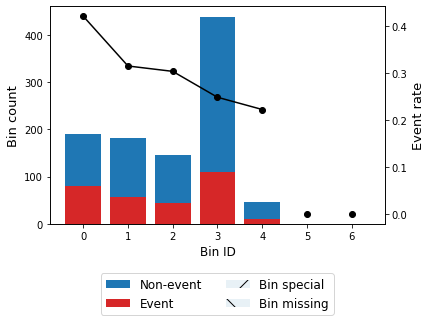

In [55]:
optbsketch.binning_table.plot(metric="event_rate")